# Template for Spectral and temporal modifications Lab


*From R. Badeau and G. Richard (with help from P. Vernhet); MAJ:2019,2024*

**python version >=3.6**

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython
from copy import deepcopy
from math import ceil
import soundfile as sf

## Functions

In [49]:
def plot_sound(data, times, name="default_name", save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel("time (s)")
    plt.ylabel("amplitude")
    if save:
        plt.savefig(name + ".png", dpi=100)
    plt.show()


def nextpow2(x):
    assert x > 0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2 ** (p - 1) < x <= x_
    return x_


def period(x, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7):
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin * Fs).astype(int)
    Nmax = 1 + np.floor(Pmax * Fs).astype(int)
    Nmax = np.min([Nmax, N])

    Nfft = nextpow2(2 * N - 1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I + Nmin
    corr = (rmax / r[0]) * (N / (N - P))
    voiced = corr > seuil
    if not (voiced):
        P = np.round(10e-3 * Fs)

    return int(P), voiced

## Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [50]:
filename = 'aeiou.wav'
file_path = os.path.join(os.getcwd(), filename) 

### **Using Soundfile**

In [51]:
x, Fs= sf.read(file_path)

In [52]:
IPython.display.Audio(file_path)

In [53]:
timestep = 1/float(Fs)
times = np.arange(len(x))*timestep

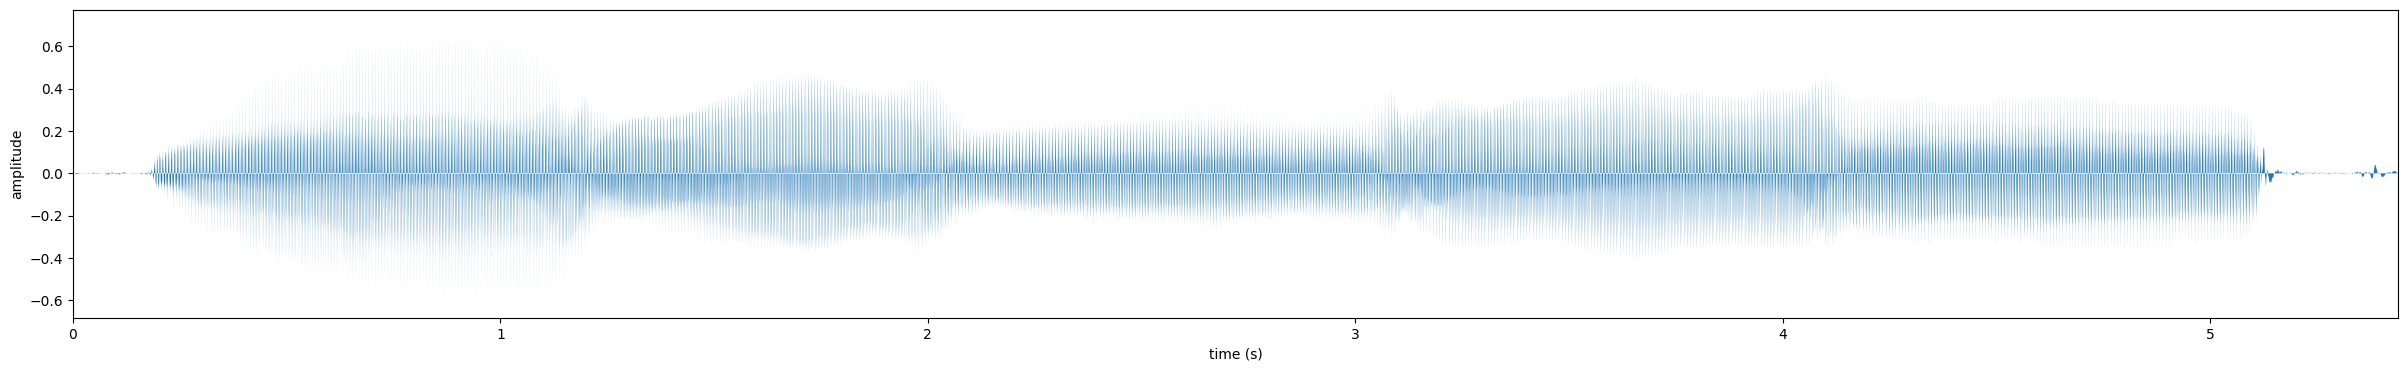

In [54]:
plot_sound(x, times)

In [55]:
sf.write('new_aeiou.wav',x, samplerate=Fs) # to write a new wave file

# Extraction of the analysis marks

In [56]:
def  AnalysisPitchMarks(s, Fs, Pmin=1 / 300, Pmax=1 / 80, seuil=0.7) :
# @brief extracts the analysis marks
# @param s the signal to be analyzed
# @param Fs sampling frequency
# @return A matrix A will contain the times and pitches corresponding to each analysis mark
#         A[0,:] = ta(n), A[1,:] = voiced(n), A[2,:] = Pa(n)
    N = len(s)
    if N < 0:
        raise ValueError('The signal must be non-empty')
    
    A = []
    i = 0
    while i < N:
        P, voiced = period(s[i:], Fs, Pmin, Pmax, seuil)
        A.append([i / Fs, voiced, P])
        i += P
    A = np.array(A)

    return A.T

In [57]:
A = AnalysisPitchMarks(x, Fs)

#  Synthesis and modification of the temporal and spectral scales

In [85]:
from scipy.signal.windows import hann as hanning

def Synthesis(s,Fs,A,B):
# @brief computes the synthesis signal y 
# @param s the original signal
# @param Fs the sampling frequency Fs
# @param A the analysis marks stocked in matrix A 
# @param B the synthesis marks stocked in matrix B
# @return y the synthesis signal

    ts = B[1,:]
    n = B[2,:]
    print(int(ts[-1]))
    print(int(A[2, n[-1]]))
    # vector y being initialized to the zero vector of dimension ts(kend) + Pa(n(kend)))
    y = np.zeros(int(ts[-1]) + int(A[2, n[-1]]))
    
    for k in range(1,B.shape[1]):
        # 提取以 ta(n(k)) 为中心，长度为 2*Pa(n(k))+1 的序列 x
        ta_n_k = int(A[0, n[k]])
        Pa_n_k = int(A[2, n[k]])
        x = s[ta_n_k - Pa_n_k : ta_n_k + Pa_n_k + 1]

        x_windowed = x * hanning(len(x))

        # 将窗口化的 x 序列叠加到 y
        y[ts[k] - Pa_n_k : ts[k] + Pa_n_k] += x_windowed
    return y

In [87]:
B = np.zeros(A.shape)
B[0,:] = A[0,:]
B[1,:] = range(1, A.shape[1]+1)

y = Synthesis(x, Fs, A, B)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices